In [1]:
from fastai import *
from fastai.vision import *
import torch.onnx
from torch.autograd import Variable
import os
from torch.optim import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [2]:
path = untar_data(URLs.CIFAR)

In [3]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=64)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

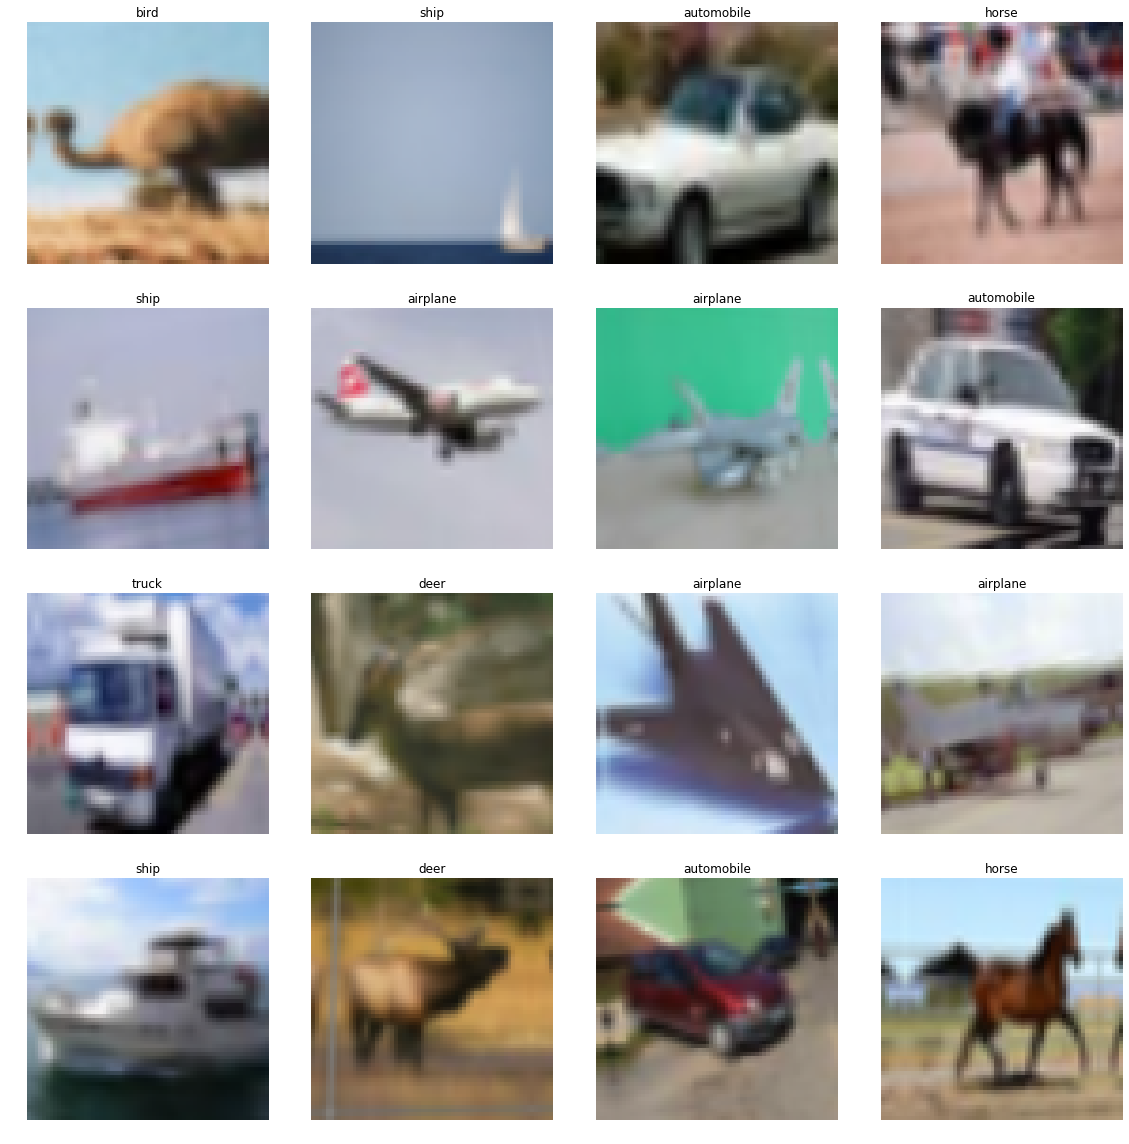

In [4]:
data.show_batch(4)

In [5]:
data.c

10

# Resnet34

# Selu

In [152]:
model = models.resnet34()

In [153]:
class SELU(nn.Module):
    def __init__(self):
        super(SELU, self).__init__()
        self.alpha = 1.6732632423543772848170429916717
        self.scale = 1.0507009873554804934193349852946
    def forward(self, x):
        temp1 = self.scale * F.relu(x)
        temp2 = self.scale * self.alpha * (F.elu(-1*F.relu(-1*x)))
        return temp1 + temp2

In [154]:
def conv_to_selu(block):
    
    for x in block:
        x.relu = SELU()
    return block

In [155]:
model.layer1[0].relu

ReLU(inplace=True)

In [156]:
model.layer1 = conv_to_selu(model.layer1)
model.layer2 = conv_to_selu(model.layer2)
model.layer3 = conv_to_selu(model.layer3)
model.layer4 = conv_to_selu(model.layer4)

In [157]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SELU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): SELU()
      (conv2): Conv2d(64, 

In [158]:
learn = None
gc.collect()

387

In [159]:
learn = Learner(
    data, model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


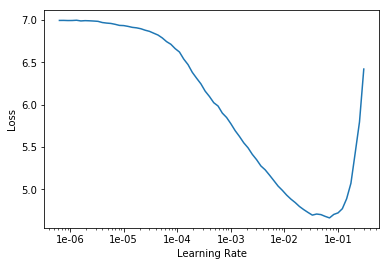

In [160]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.434922,1.362814,0.528250,00:43
1,1.160865,1.071085,0.618417,00:45
2,1.059038,1.039808,0.631000,00:45
3,0.972526,0.935601,0.674333,00:45
4,0.868044,0.833384,0.702583,00:46
5,0.827545,0.747535,0.741417,00:47
6,0.755143,0.795942,0.726750,00:46
7,0.710014,0.687681,0.759500,00:45
8,0.648408,0.673557,0.767167,00:46
9,0.607709,0.593723,0.796500,00:47


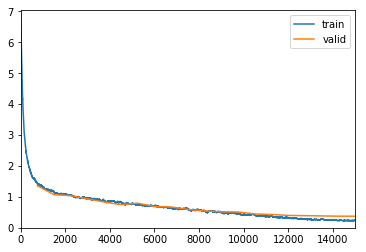

In [162]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(4e-4), wd=1e-3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


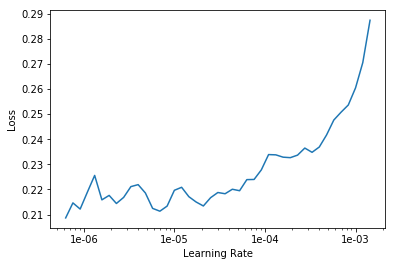

In [165]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

# Same thing with relu

In [167]:
learn = None

In [168]:
learn = Learner(
    data, models.resnet34(), metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


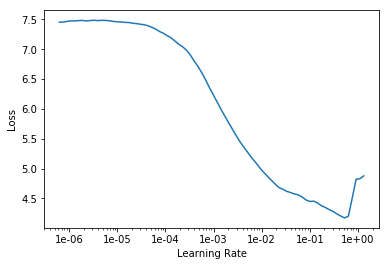

In [169]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.298911,1.322005,0.513583,00:41
1,1.142089,1.228967,0.574917,00:41
2,0.980172,1.229564,0.606500,00:41
3,0.898171,0.838585,0.711333,00:42
4,0.817209,0.794567,0.725917,00:41
5,0.716103,0.657435,0.773833,00:41
6,0.645321,0.642512,0.780500,00:44
7,0.577674,0.685952,0.766833,00:42
8,0.530049,0.513796,0.821083,00:42
9,0.492265,0.569389,0.806167,00:43


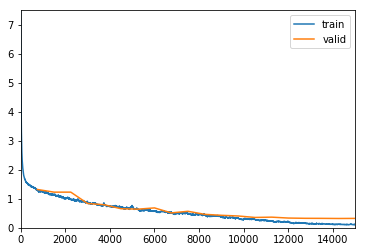

In [170]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(4e-3), wd=1e-3)

# CONCLUSION -> relu>selu

# Densenet

In [222]:
path = untar_data(URLs.CIFAR_100)

In [223]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=64)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

# Selu

In [231]:
model = models.densenet121()

In [232]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [233]:
model.features.relu0 = SELU()
for x in model.features.denseblock1.children():
    x.relu1,x.relu2 = SELU(),SELU()
for x in model.features.denseblock2.children():
    x.relu1,x.relu2 = SELU(),SELU()
for x in model.features.denseblock3.children():
    x.relu1,x.relu2 = SELU(),SELU()
for x in model.features.denseblock4.children():
    x.relu1,x.relu2 = SELU(),SELU()


In [234]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): SELU()
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): SELU()
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): SELU()
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): SELU()
        (conv1): Conv2d(9

In [235]:
learn = None
gc.collect()

7867

# SELU

In [236]:
learn = Learner(
    data, model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


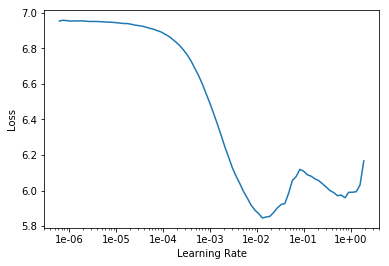

In [237]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,4.913087,4.733593,0.114750,02:13
1,3.724014,3.588762,0.201000,02:12
2,3.151418,3.000845,0.271917,02:10
3,2.745013,2.659117,0.325917,02:13
4,2.473694,2.482067,0.367667,02:15
5,2.255514,2.154659,0.428917,02:12
6,2.106083,2.047707,0.454500,02:14
7,1.928874,1.893893,0.485083,02:15
8,1.823897,1.804321,0.508917,02:17
9,1.675016,1.739842,0.525583,02:14


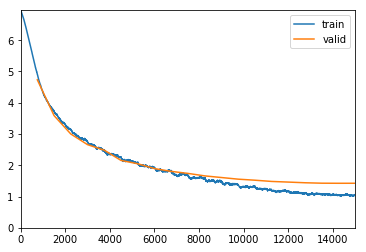

In [239]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4), wd=1e-3)

# Same thing with relu

In [240]:
model = models.densenet121()

In [241]:
learn = None

In [242]:
learn = Learner(
    data, model, metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph
).to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


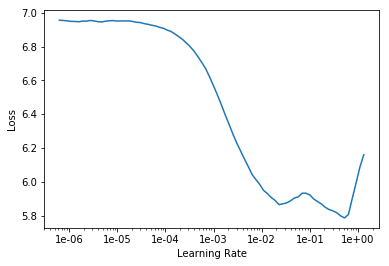

In [243]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.297210,3.219888,0.220083,01:53
1,2.880365,2.796324,0.289917,01:49
2,2.591685,2.654157,0.331000,01:55
3,2.225494,2.255099,0.411667,01:53
4,2.079384,2.027110,0.454917,01:45
5,1.865173,1.826852,0.502083,01:47
6,1.697261,1.891164,0.505417,01:43
7,1.572238,1.650281,0.557500,01:44
8,1.411018,1.533233,0.575000,01:44
9,1.248626,1.466562,0.596917,01:44


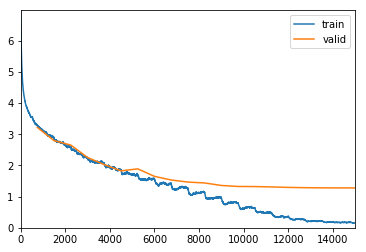

In [244]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(4e-3), wd=1e-3)

# Conclusion -> relu overfit. Selu does better